In [4]:
from pathlib import Path
import sys
sys.path.append(str(Path().resolve().parent))

from lib.aminoacids import AA_TO_CODONS_MULTI_CODON_FAMILIES, AA_1_TO_3
from lib.data_access_helpers import load_elongation_rates, load_rscu_data

In [5]:
elongation_rates = load_elongation_rates()
rscu_data = load_rscu_data("../data/rscu/dep_genes_w21_d35.tsv")

/var/folders/0d/ym925d856kddc5kzz6322lb00000gn/T/ipykernel_71722/73423249.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.97])  # leave space for colorbar + title


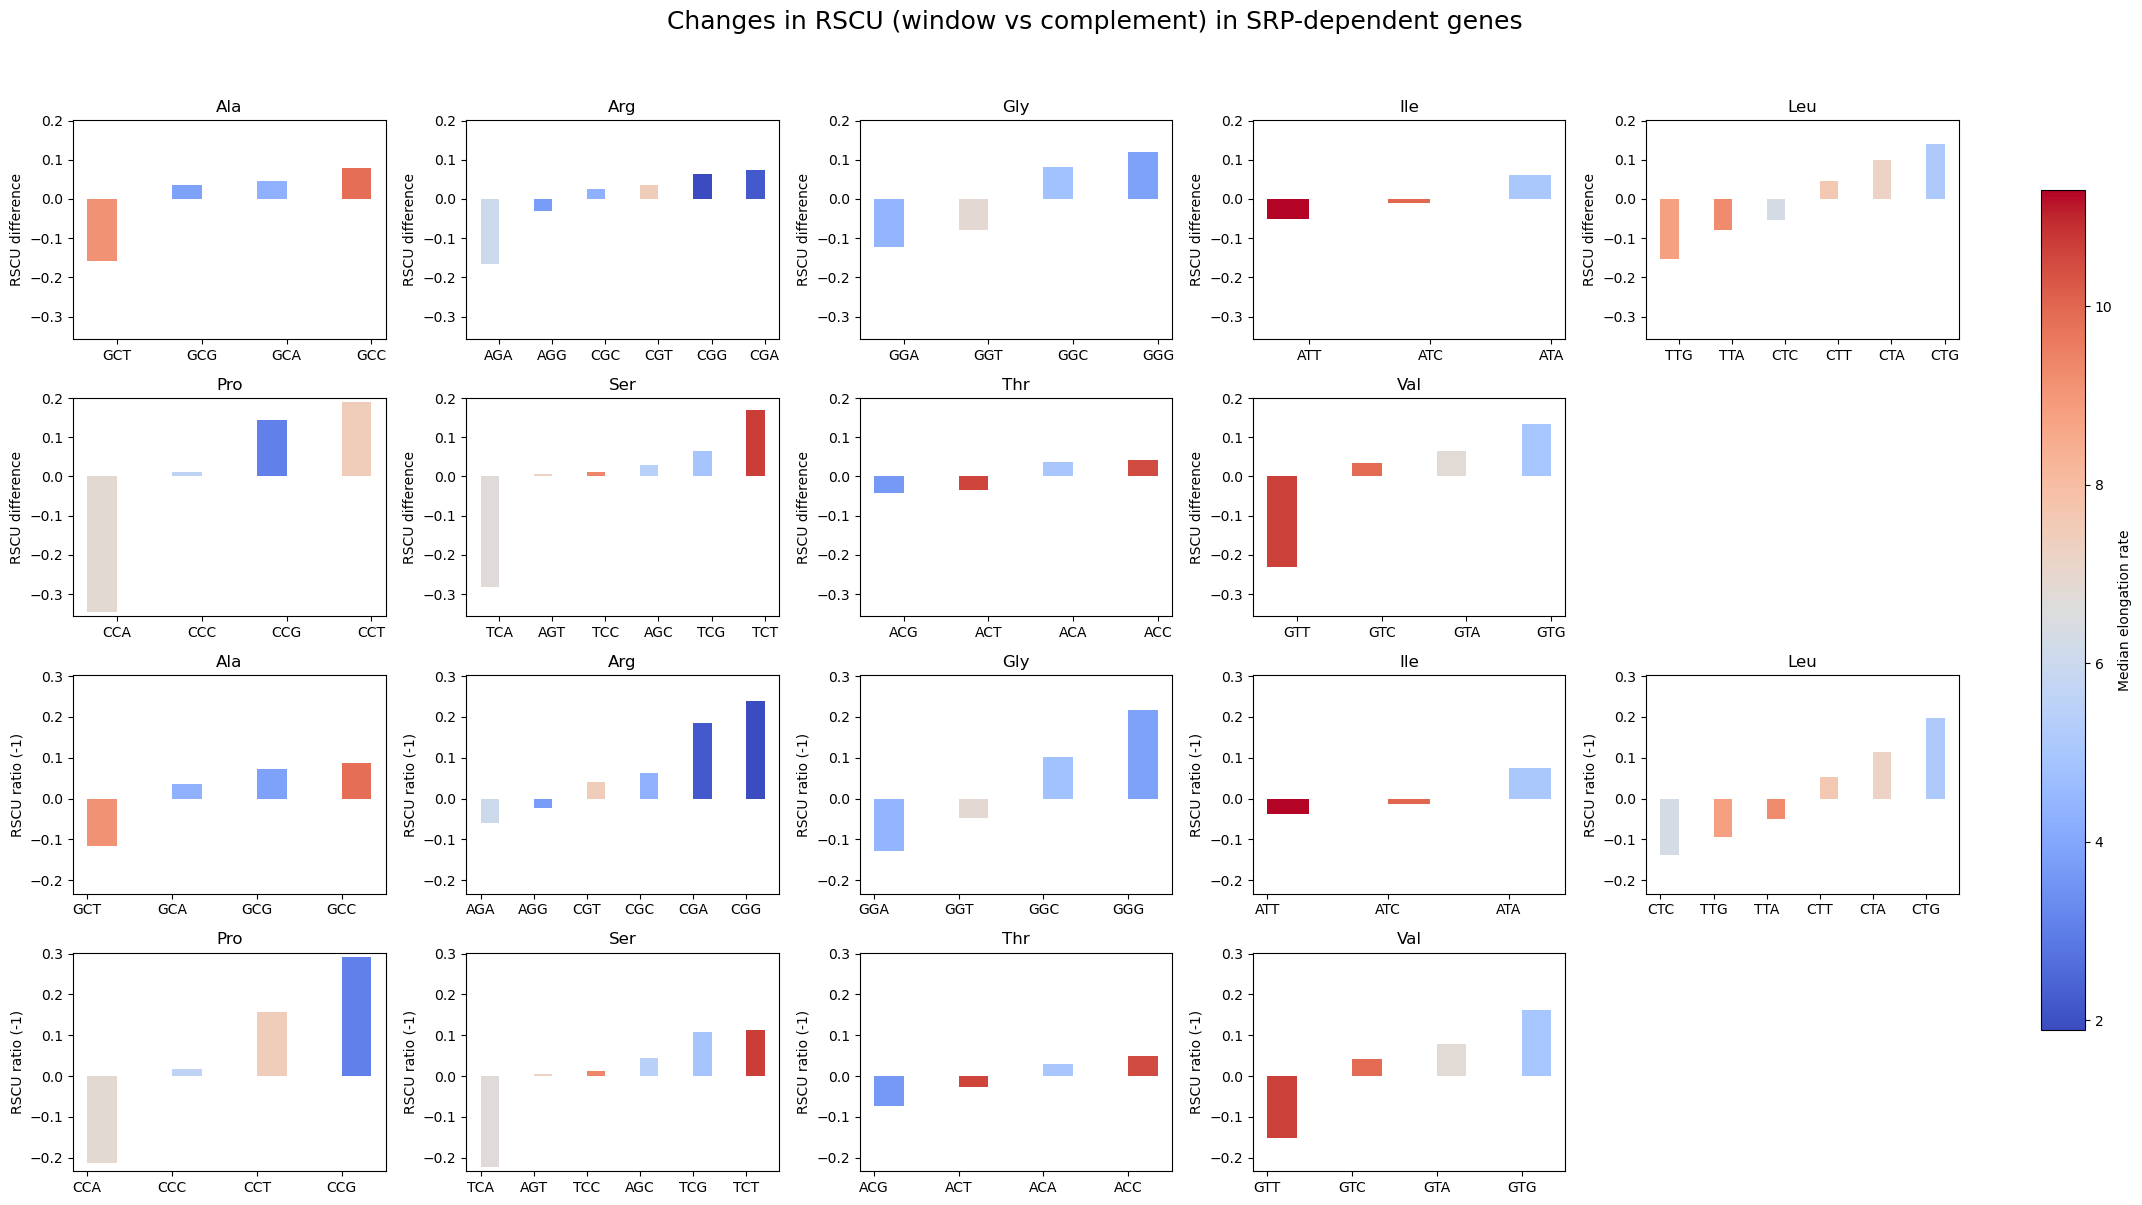

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Bigger figure for clarity
fig, axs = plt.subplots(4, 5, figsize=(22, 12))

plt_count = 0
cmap = cm.coolwarm  # colormap

# --- 1. Precompute global ranges ---
global_min_diff = float('inf')
global_max_diff = float('-inf')
global_min_ratio = float('inf')
global_max_ratio = float('-inf')
global_min_elg = float('inf')
global_max_elg = float('-inf')

for aa, codons in AA_TO_CODONS_MULTI_CODON_FAMILIES.items():
    if len(codons) < 3:
        continue
    diffs = [rscu_data.loc[c]['window'] - rscu_data.loc[c]['complement'] for c in codons]
    ratios = [rscu_data.loc[c]['window'] / rscu_data.loc[c]['complement'] for c in codons]
    elgs = [elongation_rates.loc[c]['median_elongation_rate'] for c in codons]

    global_min_diff = min(global_min_diff, min(diffs))
    global_max_diff = max(global_max_diff, max(diffs))
    global_min_ratio = min(global_min_ratio, min(ratios))
    global_max_ratio = max(global_max_ratio, max(ratios))
    global_min_elg = min(global_min_elg, min(elgs))
    global_max_elg = max(global_max_elg, max(elgs))

# --- 2. Global color normalization ---
norm_global = mcolors.Normalize(vmin=global_min_elg, vmax=global_max_elg)

# --- 3. Plot each amino acid ---
for aa in AA_TO_CODONS_MULTI_CODON_FAMILIES:
    codons = AA_TO_CODONS_MULTI_CODON_FAMILIES[aa]
    n_i = len(codons)

    if n_i < 3:
        continue

    # initialize arrays
    aa_elongation_rates = np.zeros(n_i)
    aa_rscu_diffs = np.zeros(n_i)
    aa_rscu_ratios = np.zeros(n_i)

    for i, codon in enumerate(codons):
        aa_elongation_rates[i] = elongation_rates.loc[codon]['median_elongation_rate']
        aa_rscu_diffs[i] = rscu_data.loc[codon]['window'] - rscu_data.loc[codon]['complement']
        aa_rscu_ratios[i] = rscu_data.loc[codon]['window'] / rscu_data.loc[codon]['complement']

    # rank by RSCU difference
    sort_idx_diff = aa_rscu_diffs.argsort()
    ranked_codon_diff = [codons[i] for i in sort_idx_diff]
    ranked_RSCU_diff = [aa_rscu_diffs[i] for i in sort_idx_diff]
    ranked_elg_diff = [aa_elongation_rates[i] for i in sort_idx_diff]

    # rank by RSCU ratio
    sort_idx_ratio = aa_rscu_ratios.argsort()
    ranked_codon_ratio = [codons[i] for i in sort_idx_ratio]
    ranked_RSCU_ratio = [aa_rscu_ratios[i] for i in sort_idx_ratio]
    ranked_elg_ratio = [aa_elongation_rates[i] for i in sort_idx_ratio]

    # global color mapping
    colors_diff = cmap(norm_global(ranked_elg_diff))
    colors_ratio = cmap(norm_global(ranked_elg_ratio))

    width = 0.35
    ax_top = axs[plt_count//5, plt_count%5]
    ax_bottom = axs[plt_count//5+2, plt_count%5]

    # plot bars
    ax_top.bar(np.arange(n_i), ranked_RSCU_diff, width, color=colors_diff)
    ax_bottom.bar(np.arange(n_i)+width, np.array(ranked_RSCU_ratio)-1, width, color=colors_ratio)

    # titles and labels
    ax_top.set_title(AA_1_TO_3[aa])
    ax_bottom.set_title(AA_1_TO_3[aa])
    ax_top.set_ylabel('RSCU difference')
    ax_bottom.set_ylabel('RSCU ratio (-1)')
    ax_top.set_xticks(np.arange(n_i)+width/2)
    ax_bottom.set_xticks(np.arange(n_i)+width/2)
    ax_top.set_xticklabels(ranked_codon_diff)
    ax_bottom.set_xticklabels(ranked_codon_ratio)

    # set global axis limits
    ax_top.set_ylim(global_min_diff - 0.01, global_max_diff + 0.01)
    ax_bottom.set_ylim(global_min_ratio - 1.01, global_max_ratio - 0.99)

    plt_count += 1

# --- 4. Clean up empty axes ---
fig.delaxes(axs[1,4])
fig.delaxes(axs[3,4])

# --- 5. Single shared colorbar OUTSIDE the grid (right side) ---
sm = cm.ScalarMappable(cmap=cmap, norm=norm_global)
sm.set_array([])
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label("Median elongation rate")

plt.suptitle('Changes in RSCU (window vs complement) in SRP-dependent genes', y=1.0, fontsize=18)
plt.tight_layout(rect=[0, 0, 0.9, 0.97])  # leave space for colorbar + title
plt.show()
